### Project 3: Gaussian processes and air temperature timeseries

Plotting the figures in the report

In [1]:
# Load modules
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ExpSineSquared, RBF
from sklearn.model_selection import train_test_split


In [2]:
# Import and prepare data
filename = './Data/temperature_timeseries/monthly_T_stykkisholmur.txt'
data = np.loadtxt(filename, skiprows=2)

year = data[:,1]
month = data[:,2]
T = data[:,3]  # Temperature in °C

# Reconstruct the dates so they fit into a single manageble vector.
months = np.arange(np.datetime64('1830-01', 'M'), np.datetime64('2016-01', 'M')).astype('float') # Every month from 1830-01 to 2015-12
months = months.reshape(-1,1)   # Reshape so it works for the GP regressor


In [3]:
# Define kernels

# Start by defining some sub-kernels
subkernel_trend = 0.5**2 * (DotProduct(sigma_0=1) * RBF(length_scale=185))  # Long-term trend, SE*Lin
subkernel_period = 12**2 * (ExpSineSquared(length_scale=10, periodicity=1, periodicity_bounds="fixed")
                   * RBF(length_scale=100, length_scale_bounds=(1e-8,1e5)))  # Yearly cycle, Per*SE
subkernel_noise = 0.5**2 * (WhiteKernel(noise_level=0.5) + RBF(length_scale=0.1))  # Noise, normally distributed, WN

# Construct the final kernel
kernel_tseries = subkernel_trend + subkernel_period + subkernel_noise

# One simpler kernel
kernel_basic = ExpSineSquared()


---
### Vary the number of optimizer restarts

In [4]:
# Loop over many different iterations of n_restart_optimizer and calculate the correlation.
# Do this for five different random states to demonstrate variability.

var_noise = 0.5                    # Artificial noise to add to the data
rnd_states = [12, 24, 42, 84, 96]  # Different random states
n_restopt_range = np.arange(0,9,1) # The range of number of restarts.


In [ ]:
# Loop over the different random states and number of optimizer restarts

corr_restopt_tseries = np.zeros((len(rnd_states),len(n_restopt_range))) # Initialize the vector for the corr.coefs.
corr_restopt_period  = np.zeros((len(rnd_states),len(n_restopt_range))) # Initialize the vector for the corr.coefs.
corr_restopt_basic   = np.zeros((len(rnd_states),len(n_restopt_range))) # Initialize the vector for the corr.coefs.

for r in tqdm(range(len(rnd_states))):
    # Split the data into train-test for different random states
    months_train, months_test, T_train, T_test = train_test_split(months, T, test_size=0.50,
                                                                  random_state=rnd_states[r], shuffle=True)
    
    for i in tqdm(n_restopt_range):
        # Define the GP regression models
        gp_model_tseries = GaussianProcessRegressor(kernel=kernel_tseries, alpha=var_noise, random_state=24,
                                        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt_range[i],
                                        normalize_y=False)
        
        gp_model_period = GaussianProcessRegressor(kernel=subkernel_period, alpha=var_noise, random_state=24,
                                        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt_range[i],
                                        normalize_y=False)
        
        gp_model_basic = GaussianProcessRegressor(kernel=kernel_basic, alpha=var_noise, random_state=24,
                                        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt_range[i],
                                        normalize_y=False)
        
        # Fit the model using the training data
        gp_model_tseries.fit(months_train, T_train)
        gp_model_period.fit(months_train, T_train)
        gp_model_basic.fit(months_train, T_train)
        
        # Simulate the testing data
        T_pred_tseries = gp_model_tseries.predict(months_test, return_std=False)
        T_pred_period = gp_model_period.predict(months_test, return_std=False)
        T_pred_basic = gp_model_basic.predict(months_test, return_std=False)
    
        # Calculate the correlation coefficient
        corr_restopt_tseries[r,i] = np.corrcoef(T_test, T_pred_tseries)[1,0]
        corr_restopt_period[r,i] = np.corrcoef(T_test, T_pred_period)[1,0]
        corr_restopt_basic[r,i] = np.corrcoef(T_test, T_pred_basic)[1,0]



In [ ]:
# Save the results
np.savetxt('gp_timeseries_nrestoptimizer_tseries.txt', corr_restopt_tseries)
np.savetxt('gp_timeseries_nrestoptimizer_period.txt', corr_restopt_period)
np.savetxt('gp_timeseries_nrestoptimizer_basic.txt', corr_restopt_basic)


In [5]:
# Load the results
corr_restopt_tseries = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_nrestoptimizer_tseries.txt')
corr_restopt_period = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_nrestoptimizer_period.txt')
corr_restopt_basic = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_nrestoptimizer_basic.txt')


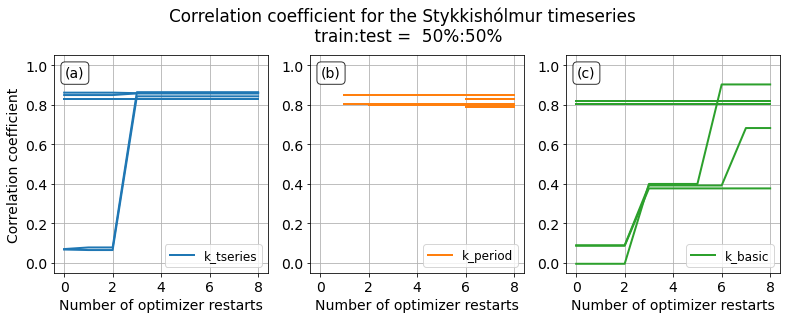

In [7]:
# Plot
plt.figure(figsize=(13,4))
plt.suptitle('Correlation coefficient for the Stykkishólmur timeseries \n train:test =  50%:50%', y=1.05)

txtbox_props = dict(boxstyle='round', facecolor='white', alpha=0.8)

ax1 = plt.subplot(1,3,1)
plt.plot(n_restopt_range, corr_restopt_tseries[0,:], color='tab:blue', lw=2, label='k_tseries')
plt.plot(n_restopt_range, corr_restopt_tseries[1,:], color='tab:blue', lw=2)
plt.plot(n_restopt_range, corr_restopt_tseries[2,:], color='tab:blue', lw=2)
plt.plot(n_restopt_range, corr_restopt_tseries[3,:], color='tab:blue', lw=2)
plt.plot(n_restopt_range, corr_restopt_tseries[4,:], color='tab:blue', lw=2)
plt.legend(loc="lower right")
plt.ylim([-0.05,1.05])
plt.xlim([-0.4,8.4])
plt.xlabel('Number of optimizer restarts')
plt.ylabel('Correlation coefficient')
plt.grid()
ax1.text(0.05, 0.9, '(a)', transform=ax1.transAxes, fontsize=14, bbox=txtbox_props)

ax2 = plt.subplot(1,3,2)
plt.plot(n_restopt_range, corr_restopt_period[0,:], color='tab:orange', lw=2, label='k_period')
plt.plot(n_restopt_range, corr_restopt_period[1,:], color='tab:orange', lw=2)
plt.plot(n_restopt_range, corr_restopt_period[2,:], color='tab:orange', lw=2)
plt.plot(n_restopt_range, corr_restopt_period[3,:], color='tab:orange', lw=2)
plt.plot(n_restopt_range, corr_restopt_period[4,:], color='tab:orange', lw=2)
plt.legend(loc="lower right")
plt.ylim([-0.05,1.05])
plt.xlim([-0.4,8.4])
plt.xlabel('Number of optimizer restarts')
plt.grid()
ax2.text(0.05, 0.9, '(b)', transform=ax2.transAxes, fontsize=14, bbox=txtbox_props)

ax3 = plt.subplot(1,3,3)
plt.plot(n_restopt_range, corr_restopt_basic[0,:], color='tab:green', lw=2, label='k_basic')
plt.plot(n_restopt_range, corr_restopt_basic[1,:], color='tab:green', lw=2)
plt.plot(n_restopt_range, corr_restopt_basic[2,:], color='tab:green', lw=2)
plt.plot(n_restopt_range, corr_restopt_basic[3,:], color='tab:green', lw=2)
plt.plot(n_restopt_range, corr_restopt_basic[4,:], color='tab:green', lw=2)
plt.legend(loc="lower right")
plt.ylim([-0.05,1.05])
plt.xlim([-0.4,8.4])
plt.xlabel('Number of optimizer restarts')
plt.grid()
ax3.text(0.05, 0.9, '(c)', transform=ax3.transAxes, fontsize=14, bbox=txtbox_props)

plt.rc('font', size=14)
plt.rc('legend', fontsize=12)


###### Look more closely at a case where $k_{period}$ fails

In [8]:
# Split data into test and train
months_train, months_test, T_train, T_test = train_test_split(months, T, test_size=0.50,
                                                              random_state=84, shuffle=True)


In [ ]:
# Define the GP regression model
var_noise = 0.5     # Artificial noise to add to the training data
gp_regressor = GaussianProcessRegressor(kernel=subkernel_period, alpha=var_noise, random_state=24,
                                        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1,
                                        normalize_y=False)

# Fit the model to the training data
gp_regressor.fit(months_train, T_train)

#%% Make a recontruction
T_pred_train = gp_regressor.predict(months_train, return_std=False) # Simulate all existing data.
T_pred_test = gp_regressor.predict(months_test, return_std=False)    # Simulate testing data.
T_pred_all = gp_regressor.predict(months, return_std=False)           # Simulate all data

In [ ]:
# Save the results
np.savetxt('gp_timeseries_Tpredtrain_kperiod.txt', T_pred_train)
np.savetxt('gp_timeseries_Tpredtest_kperiod.txt', T_pred_test)
np.savetxt('gp_timeseries_Tpredall_kperiod.txt', T_pred_all)


In [9]:
# Load the results
T_pred_train = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtrain_kperiod.txt')
T_pred_test = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtest_kperiod.txt')
T_pred_all = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredall_kperiod.txt')


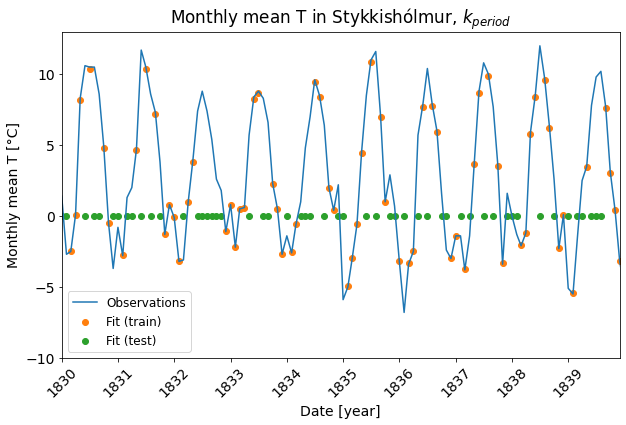

In [10]:
# Plot a snippet of the data
plt.figure(figsize=(10,6))
plt.plot(np.ravel(months).astype('datetime64[M]'), T, color='tab:blue', label='Observations')

plt.scatter(np.ravel(months_train).astype('datetime64[M]'), T_pred_train, color='tab:orange', label='Fit (train)')
plt.scatter(np.ravel(months_test).astype('datetime64[M]'), T_pred_test, color='tab:green', label='Fit (test)')


#plt.xlabel('Date [yyyy-mm]')
plt.xlabel('Date [year]')
plt.ylabel('Monthly mean T [°C]')
plt.title('Monthly mean T in Stykkishólmur, $k_{period}$')

plt.xticks(rotation=45)  # Rotates the x axis ticks

plt.legend(loc='lower left')
plt.xlim([np.datetime64('1830-01'),np.datetime64('1839-12')])
plt.ylim([-10, 13])

plt.rc('font', size=14)


---
### Vary the noise added to the training data

In [11]:
# Loop over many different noise variances and calculate the correlation and RMSE.
# Do this for five different random state to demonstrate variability.
# Note that now k_period has been dropped.

var_noise = [0.05, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5] # Artificial noise to add to the data
rnd_states = [12, 24, 42, 84, 96]                  # Different random states
n_restopt = 10                                     # The range of number of restarts.


In [ ]:
# Loop over the different random states and noise variances

corr_tseries = np.zeros((len(rnd_states),len(var_noise))) # Initialize the vector for the corr.coefs.
corr_basic = np.zeros((len(rnd_states),len(var_noise)))   # Initialize the vector for the corr.coefs.

rmse_tseries = np.zeros((len(rnd_states),len(var_noise))) # Initialize the vector for the RMSE
rmse_basic = np.zeros((len(rnd_states),len(var_noise)))   # Initialize the vector for the RMSE

for r in tqdm(range(len(rnd_states))):
    # Split the data into train-test for different random states
    months_train, months_test, T_train, T_test = train_test_split(months, T, test_size=0.50,
                                                                  random_state=rnd_states[r], shuffle=True)
        
    for i in tqdm(range(len(var_noise))):
        # Define the GP regression models
        gp_model_tseries = GaussianProcessRegressor(kernel=kernel_tseries1, alpha=var_noise[i], random_state=24,
                                        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt,
                                        normalize_y=False)
        
        gp_model_basic = GaussianProcessRegressor(kernel=kernel_basic1, alpha=var_noise[i], random_state=24,
                                        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt,
                                        normalize_y=False)
            
        # Fit the model using the training data
        gp_model_tseries.fit(months_train, T_train)
        gp_model_basic.fit(months_train, T_train)
           
        # Simulate the testing and training data
        T_pred_tseries = gp_model_tseries.predict(months_test, return_std=False)
        T_pred_basic = gp_model_basic.predict(months_test, return_std=False)
        
        # Calculate the correlation coefficient
        corr_tseries[r,i] = np.corrcoef(T_test, T_pred_tseries)[1,0]        
        corr_basic[r,i] = np.corrcoef(T_test, T_pred_basic)[1,0]
                
        # Calculate the RMSE
        rmse_tseries[r,i] = np.sqrt(np.mean((T_test - T_pred_tseries)**2))
        rmse_basic[r,i] = np.sqrt(np.mean((T_test - T_pred_basic)**2))


In [ ]:
# Save the results
np.savetxt('gp_timeseries_noise_tseries.txt', corr_tseries)
np.savetxt('gp_timeseries_noise_basic.txt', corr_basic)

np.savetxt('gp_Tpredtest_noise_rmse_tseries.txt', rmse_tseries)
np.savetxt('gp_Tpredtest_noise_rmse_basic.txt', rmse_basic)


In [12]:
# Load the results
corr_tseries = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_noise_tseries.txt')
corr_basic = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_noise_basic.txt')

rmse_tseries = np.loadtxt('saved_results/temperature_timeseries/gp_Tpredtest_noise_rmse_tseries.txt')
rmse_basic = np.loadtxt('saved_results/temperature_timeseries/gp_Tpredtest_noise_rmse_basic.txt')


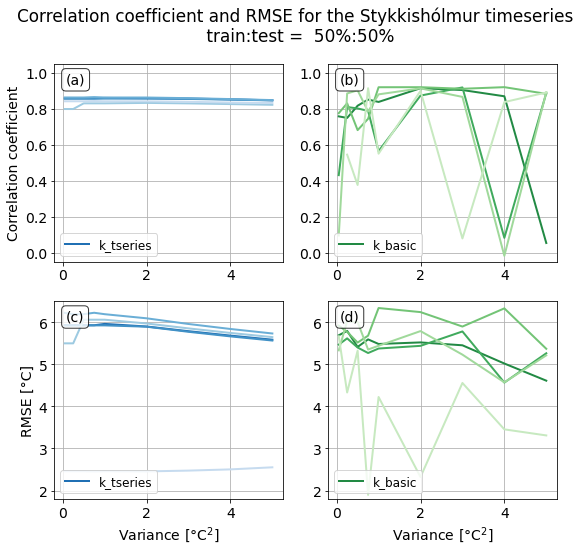

In [13]:
# Plot
cm_blues = plt.cm.Blues(np.linspace(0.25, 0.75, len(rnd_states)))[::-1]   # The [::-1] is to reverse the vector
cm_greens = plt.cm.Greens(np.linspace(0.25, 0.75, len(rnd_states)))[::-1] # The [::-1] is to reverse the vector

plt.figure(figsize=(9,8))
plt.suptitle('Correlation coefficient and RMSE for the Stykkishólmur timeseries \n train:test =  50%:50%', y=0.98)

txtbox_props = dict(boxstyle='round', facecolor='white', alpha=0.8)

ax1 = plt.subplot(2,2,1)
plt.plot(var_noise, corr_tseries[0,:], color=cm_blues[0], lw=2, label='k_tseries')
plt.plot(var_noise, corr_tseries[1,:], color=cm_blues[1], lw=2)
plt.plot(var_noise, corr_tseries[2,:], color=cm_blues[2], lw=2)
plt.plot(var_noise, corr_tseries[3,:], color=cm_blues[3], lw=2)
plt.plot(var_noise, corr_tseries[4,:], color=cm_blues[4], lw=2)
plt.legend(loc="lower left")
plt.ylim([-0.05,1.05])
plt.ylabel('Correlation coefficient')
plt.grid()
ax1.text(0.05, 0.9, '(a)', transform=ax1.transAxes, fontsize=14, bbox=txtbox_props)

ax2 = plt.subplot(2,2,2)
plt.plot(var_noise, corr_basic[0,:], color=cm_greens[0], lw=2, label='k_basic')
plt.plot(var_noise, corr_basic[1,:], color=cm_greens[1], lw=2)
plt.plot(var_noise, corr_basic[2,:], color=cm_greens[2], lw=2)
plt.plot(var_noise, corr_basic[3,:], color=cm_greens[3], lw=2)
plt.plot(var_noise, corr_basic[4,:], color=cm_greens[4], lw=2)
plt.legend(loc="lower left")
plt.ylim([-0.05,1.05])
plt.grid()
ax2.text(0.05, 0.9, '(b)', transform=ax2.transAxes, fontsize=14, bbox=txtbox_props)

ax3 = plt.subplot(2,2,3)
plt.plot(var_noise, rmse_tseries[0,:], color=cm_blues[0], lw=2, label='k_tseries')
plt.plot(var_noise, rmse_tseries[1,:], color=cm_blues[1], lw=2)
plt.plot(var_noise, rmse_tseries[2,:], color=cm_blues[2], lw=2)
plt.plot(var_noise, rmse_tseries[3,:], color=cm_blues[3], lw=2)
plt.plot(var_noise, rmse_tseries[4,:], color=cm_blues[4], lw=2)
plt.legend(loc="lower left")
plt.ylim([1.8,6.5])
plt.xlabel('Variance [°C$^2$]')
plt.ylabel('RMSE [°C]')
plt.grid()
ax3.text(0.05, 0.9, '(c)', transform=ax3.transAxes, fontsize=14, bbox=txtbox_props)

ax4 = plt.subplot(2,2,4)
plt.plot(var_noise, rmse_basic[0,:], color=cm_greens[0], lw=2, label='k_basic')
plt.plot(var_noise, rmse_basic[1,:], color=cm_greens[1], lw=2)
plt.plot(var_noise, rmse_basic[2,:], color=cm_greens[2], lw=2)
plt.plot(var_noise, rmse_basic[3,:], color=cm_greens[3], lw=2)
plt.plot(var_noise, rmse_basic[4,:], color=cm_greens[4], lw=2)
plt.legend(loc="lower left")
plt.ylim([1.8,6.5])
plt.xlabel('Variance [°C$^2$]')
plt.grid()
ax4.text(0.05, 0.9, '(d)', transform=ax4.transAxes, fontsize=14, bbox=txtbox_props)

plt.rc('font', size=14)
plt.rc('legend', fontsize=12)


---
### Vary the ratio between training and testing data

In [14]:
# Loop over many different iterations of training sizes and calculate the correlation and RMSE.
# Do this for five different random states to demonstrate variability.
# Note that now k_period has been dropped.

var_noise = 1                     # Artificial noise to add to the data
rnd_states = [12, 24, 42, 84, 96] # Different random states
n_restopt = 10                    # The range of number of restarts.

test_sizes = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9] # Different test sizes


In [ ]:
# Loop over the different random states and train/test ratios

corr_tseries = np.zeros((len(rnd_states),len(test_sizes))) # Initialize the vector for the corr.coefs.
corr_basic = np.zeros((len(rnd_states),len(test_sizes)))   # Initialize the vector for the corr.coefs.

rmse_tseries = np.zeros((len(rnd_states),len(test_sizes))) # Initialize the vector for the RMSE
rmse_basic = np.zeros((len(rnd_states),len(test_sizes)))   # Initialize the vector for the RMSE

for r in tqdm(range(len(rnd_states))):   
    for i in tqdm(range(len(test_sizes))):
        # Split the data into train-test for different random states and different train/test ratios
        months_train, months_test, T_train, T_test = train_test_split(months, T, test_size=test_sizes[i],
                                                                      random_state=rnd_states[r], shuffle=True)
        
        # Define the GP regression models
        gp_model_tseries = GaussianProcessRegressor(kernel=kernel_tseries, alpha=var_noise, random_state=24,
                                        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt,
                                        normalize_y=False)
        
        gp_model_basic = GaussianProcessRegressor(kernel=kernel_basic, alpha=var_noise, random_state=24,
                                        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt,
                                        normalize_y=False)
            
        # Fit the model using the training data
        gp_model_tseries.fit(months_train, T_train)
        gp_model_basic.fit(months_train, T_train)
           
        # Simulate the testing and training data
        T_pred_tseries = gp_model_tseries.predict(months_test, return_std=False)
        T_pred_basic = gp_model_basic.predict(months_test, return_std=False)
        
        # Calculate the correlation coefficient
        corr_tseries[r,i] = np.corrcoef(T_test, T_pred_tseries)[1,0]
        corr_basic[r,i] = np.corrcoef(T_test, T_pred_basic)[1,0]
        
        # Calculate the RMSE
        rmse_tseries[r,i] = np.sqrt(np.mean((T_test - T_pred_tseries)**2))
        rmse_basic[r,i] = np.sqrt(np.mean((T_test - T_pred_basic)**2))


In [ ]:
# Save the results
np.savetxt('gp_timeseries_traintest_tseries.txt', corr_tseries)
np.savetxt('gp_timeseries_traintest_basic.txt', corr_basic)

np.savetxt('gp_timeseries_traintest_rmse_tseries.txt', rmse_tseries)
np.savetxt('gp_timeseries_traintest_rmse_basic.txt', rmse_basic)


In [15]:
# Load the results
corr_tseries = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_traintest_tseries.txt')
corr_basic = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_traintest_basic.txt')

rmse_tseries = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_traintest_rmse_tseries.txt')
rmse_basic = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_traintest_rmse_basic.txt')


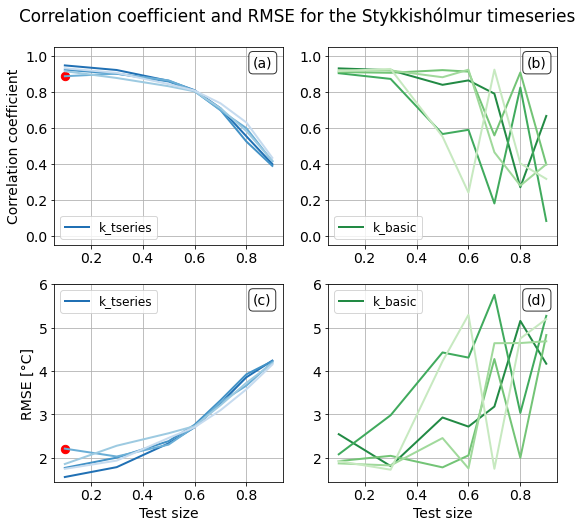

In [16]:
# Plot
cm_blues = plt.cm.Blues(np.linspace(0.25, 0.75, len(rnd_states)))[::-1]   # The [::-1] is to reverse the vector
cm_greens = plt.cm.Greens(np.linspace(0.25, 0.75, len(rnd_states)))[::-1] # The [::-1] is to reverse the vector

plt.figure(figsize=(9,8))
plt.suptitle('Correlation coefficient and RMSE for the Stykkishólmur timeseries', y=0.95)

txtbox_props = dict(boxstyle='round', facecolor='white', alpha=0.8)

ax1 = plt.subplot(2,2,1)
plt.plot(test_sizes, corr_tseries[0,:], color=cm_blues[0], lw=2, label='k_tseries')
plt.plot(test_sizes, corr_tseries[1,:], color=cm_blues[1], lw=2)
plt.plot(test_sizes, corr_tseries[2,:], color=cm_blues[2], lw=2)
plt.plot(test_sizes, corr_tseries[3,:], color=cm_blues[3], lw=2)
plt.plot(test_sizes, corr_tseries[4,:], color=cm_blues[4], lw=2)
plt.scatter(test_sizes[0], corr_tseries[2,0], color='red', marker='o', s=70)
plt.legend(loc="lower left")
plt.ylim([-0.05,1.05])
plt.ylabel('Correlation coefficient')
plt.grid()
ax1.text(0.87, 0.9, '(a)', transform=ax1.transAxes, fontsize=14, bbox=txtbox_props)

ax2 = plt.subplot(2,2,2)
plt.plot(test_sizes, corr_basic[0,:], color=cm_greens[0], lw=2, label='k_basic')
plt.plot(test_sizes, corr_basic[1,:], color=cm_greens[1], lw=2)
plt.plot(test_sizes, corr_basic[2,:], color=cm_greens[2], lw=2)
plt.plot(test_sizes, corr_basic[3,:], color=cm_greens[3], lw=2)
plt.plot(test_sizes, corr_basic[4,:], color=cm_greens[4], lw=2)
plt.legend(loc="lower left")
plt.ylim([-0.05,1.05])
plt.grid()
ax2.text(0.87, 0.9, '(b)', transform=ax2.transAxes, fontsize=14, bbox=txtbox_props)

ax3 = plt.subplot(2,2,3)
plt.plot(test_sizes, rmse_tseries[0,:], color=cm_blues[0], lw=2, label='k_tseries')
plt.plot(test_sizes, rmse_tseries[1,:], color=cm_blues[1], lw=2)
plt.plot(test_sizes, rmse_tseries[2,:], color=cm_blues[2], lw=2)
plt.plot(test_sizes, rmse_tseries[3,:], color=cm_blues[3], lw=2)
plt.plot(test_sizes, rmse_tseries[4,:], color=cm_blues[4], lw=2)
plt.scatter(test_sizes[0], rmse_tseries[2,0], color='red', marker='o', s=70)
plt.legend(loc="upper left")
plt.ylim([1.45,6])
plt.xlabel('Test size')
plt.ylabel('RMSE [°C]')
plt.grid()
ax3.text(0.87, 0.9, '(c)', transform=ax3.transAxes, fontsize=14, bbox=txtbox_props)

ax4 = plt.subplot(2,2,4)
plt.plot(test_sizes, rmse_basic[0,:], color=cm_greens[0], lw=2, label='k_basic')
plt.plot(test_sizes, rmse_basic[1,:], color=cm_greens[1], lw=2)
plt.plot(test_sizes, rmse_basic[2,:], color=cm_greens[2], lw=2)
plt.plot(test_sizes, rmse_basic[3,:], color=cm_greens[3], lw=2)
plt.plot(test_sizes, rmse_basic[4,:], color=cm_greens[4], lw=2)
plt.legend(loc="upper left")
plt.ylim([1.45,6])
plt.xlabel('Test size')
plt.grid()
ax4.text(0.87, 0.9, '(d)', transform=ax4.transAxes, fontsize=14, bbox=txtbox_props)

plt.rc('font', size=14)
plt.rc('legend', fontsize=12)


###### Look more closely at the case indicated by the red dots in the figure above

In [17]:
# Split data into test and train
months_train, months_test, T_train, T_test = train_test_split(months, T, test_size=0.10,
                                                              random_state=42, shuffle=True)

In [ ]:
# Define the GP regression model
var_noise = 1     # Artificial noise to add to the training data
gp_model = GaussianProcessRegressor(kernel=kernel_tseries, alpha=var_noise, random_state=24,
                                    optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10,
                                    normalize_y=False)

# Train the model
gp_model.fit(months_train, T_train)

# Make a recontruction
T_pred_train, T_pred_train_std = gp_regressor.predict(months_train, return_std=True) # Simulate all existing data.
T_pred_test, T_pred_test_std = gp_regressor.predict(months_test, return_std=True)    # Simulate testing data.
T_pred_all, T_pred_all_std = gp_regressor.predict(months, return_std=True)           # Simulate all data


In [ ]:
# Save the results
np.savetxt('gp_timeseries_Tpredtrain_test10.txt', T_pred_train)
np.savetxt('gp_timeseries_Tpredtrain_test10_std.txt', T_pred_train_std)

np.savetxt('gp_timeseries_Tpredtest_test10.txt', T_pred_test)
np.savetxt('gp_timeseries_Tpredtest_test10_std.txt', T_pred_test_std)

np.savetxt('gp_timeseries_Tpredall_test10.txt', T_pred_all)
np.savetxt('gp_timeseries_Tpredall_test10_std.txt', T_pred_all_std)


In [18]:
# Load the results
T_pred_train = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtrain_test10.txt')
T_pred_train_std = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtrain_test10_std.txt')

T_pred_test = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtest_test10.txt')
T_pred_test_std = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtest_test10_std.txt')

T_pred_all = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredall_test10.txt')
T_pred_all_std = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredall_test10_std.txt')


In [19]:
# Calculate RMSE and correlation coefficient
corrcoef_test = np.corrcoef(T_test, T_pred_test)[1,0]
rmse_test = np.sqrt(np.mean((T_test - T_pred_test)**2))

corrcoef_train = np.corrcoef(T_train, T_pred_train)[1,0]
rmse_train = np.sqrt(np.mean((T_train - T_pred_train)**2))


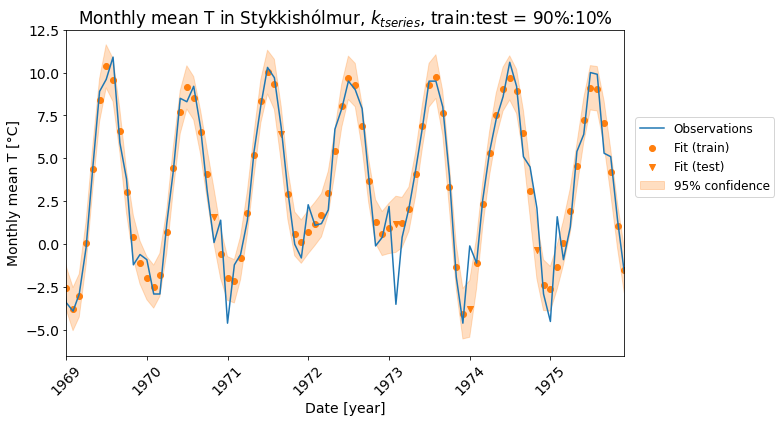

In [20]:
# Plot a snippet of the data
plt.figure(figsize=(10,6))
plt.plot(np.ravel(months).astype('datetime64[M]'), T, color='tab:blue', label='Observations')

plt.scatter(np.ravel(months_train).astype('datetime64[M]'), T_pred_train,
            color='tab:orange', label='Fit (train)')
plt.scatter(np.ravel(months_test).astype('datetime64[M]'), T_pred_test, marker='v',
            color='tab:orange', label='Fit (test)')

plt.fill_between(np.ravel(months).astype('datetime64[M]'), T_pred_all-2*T_pred_all_std, T_pred_all+2*T_pred_all_std,
                 alpha=0.25, color='tab:orange', label='95% confidence')

#plt.xlabel('Date [yyyy-mm]')
plt.xlabel('Date [year]')
plt.ylabel('Monthly mean T [°C]')
plt.title('Monthly mean T in Stykkishólmur, $k_{tseries}$, train:test = 90%:10%')

plt.xticks(rotation=45)  # Rotates the x axis ticks

plt.legend(loc='upper right', bbox_to_anchor=(1.28, 0.75))
plt.xlim([np.datetime64('1969-01'),np.datetime64('1975-12')])
plt.ylim([-6.5, 12.5])

plt.rc('font', size=14)


---
### Projection into the future

In [21]:
# Set variables
std_noise = 1    # Artificial noise to add to the training data
n_restopt = 10   # The number of optimizer restarts
rnd_states = 12  # The random state of the train/test split

# Split data into test and train
months_train, months_test, T_train, T_test = train_test_split(months, T, test_size=0.20,
                                                              random_state=rnd_states, shuffle=False)


In [ ]:
# Define and fit the GP regression models
gp_model_tseries_initialprams = GaussianProcessRegressor(kernel=kernel_tseries, alpha=std_noise, random_state=24,
                                optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0,
                                normalize_y=False)

gp_model_tseries = GaussianProcessRegressor(kernel=kernel_tseries, alpha=std_noise, random_state=24,
                                optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt,
                                normalize_y=False)
        
gp_model_basic = GaussianProcessRegressor(kernel=kernel_basic, alpha=std_noise, random_state=24,
                                optimizer='fmin_l_bfgs_b', n_restarts_optimizer=n_restopt,
                                normalize_y=False)

# Fit the model using the training data
gp_model_tseries_initialprams.fit(months_train, T_train)
gp_model_tseries.fit(months_train, T_train)
gp_model_basic.fit(months_train, T_train)
       
# Simulate the testing data
T_pred_tseries_initialparams = gp_model_tseries_initialprams.predict(months_test, return_std=False)
T_pred_tseries = gp_model_tseries.predict(months_test, return_std=False)
T_pred_basic = gp_model_basic.predict(months_test, return_std=False)

# Simulate the training data
T_pred_train_tseries_initialparams = gp_model_tseries_initialprams.predict(months_train, return_std=False)
T_pred_train_tseries = gp_model_tseries.predict(months_train, return_std=False)
T_pred_train_basic = gp_model_basic.predict(months_train, return_std=False)


In [ ]:
# Save the results
np.savetxt('gp_timeseries_Tpredtest_initialparams_future_tseries.txt', T_pred_tseries_initialparams)
np.savetxt('gp_timeseries_Tpredtrain_initialparams_future_tseries.txt', T_pred_train_tseries_initialparams)

np.savetxt('gp_timeseries_Tpredtest_future_tseries.txt', T_pred_tseries)
np.savetxt('gp_timeseries_Tpredtrain_future_tseries.txt', T_pred_train_tseries)

np.savetxt('gp_timeseries_Tpredtest_future_basic.txt', T_pred_basic)
np.savetxt('gp_timeseries_Tpredtrain_future_basic.txt', T_pred_train_basic)


In [22]:
# Load the results
T_pred_tseries_initialparams = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtest_initialparams_future_tseries.txt')
T_pred_train_tseries_initialparams = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtrain_initialparams_future_tseries.txt')

T_pred_tseries = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtest_future_tseries.txt')
T_pred_train_tseries = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtrain_future_tseries.txt')

T_pred_basic = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtest_future_basic.txt')
T_pred_train_basic = np.loadtxt('saved_results/temperature_timeseries/gp_timeseries_Tpredtrain_future_basic.txt')


In [23]:
# Calculate evaluation metrics
# Correlation coefficients
corr_test_tseries_initialparams = np.corrcoef(T_test, T_pred_tseries_initialparams)[1,0]
corr_test_tseries = np.corrcoef(T_test, T_pred_tseries)[1,0]
corr_test_basic = np.corrcoef(T_test, T_pred_basic)[1,0]

corr_train_tseries_initialparams = np.corrcoef(T_train, T_pred_train_tseries_initialparams)[1,0]
corr_train_tseries = np.corrcoef(T_train, T_pred_train_tseries)[1,0]
corr_train_basic = np.corrcoef(T_train, T_pred_train_basic)[1,0]

# RMSE
rmse_test_tseries_initialparams = np.sqrt(np.mean(np.square(T_test - T_pred_tseries_initialparams)))
rmse_test_tseries = np.sqrt(np.mean(np.square(T_test - T_pred_tseries)))
rmse_test_basic = np.sqrt(np.mean(np.square(T_test - T_pred_basic)))

rmse_train_tseries_initialparams = np.sqrt(np.mean(np.square(T_train - T_pred_train_tseries_initialparams)))
rmse_train_tseries = np.sqrt(np.mean(np.square(T_train - T_pred_train_tseries)))
rmse_train_basic = np.sqrt(np.mean(np.square(T_train - T_pred_train_basic)))


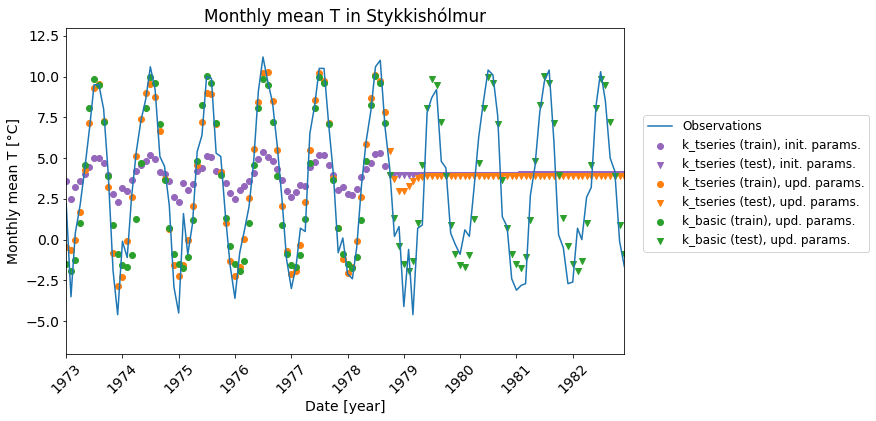

In [24]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(np.ravel(months).astype('datetime64[M]'), T, color='tab:blue', label='Observations')

plt.scatter(np.ravel(months_train).astype('datetime64[M]'), T_pred_train_tseries_initialparams, color='tab:purple', label='k_tseries (train), init. params.')
plt.scatter(np.sort(np.ravel(months_test)).astype('datetime64[M]'), T_pred_tseries_initialparams, marker='v', color='tab:purple', label='k_tseries (test), init. params.')

plt.scatter(np.ravel(months_train).astype('datetime64[M]'), T_pred_train_tseries, color='tab:orange', label='k_tseries (train), upd. params.')
plt.scatter(np.sort(np.ravel(months_test)).astype('datetime64[M]'), T_pred_tseries, marker='v', color='tab:orange', label='k_tseries (test), upd. params.')

plt.scatter(np.ravel(months_train).astype('datetime64[M]'), T_pred_train_basic, color='tab:green', label='k_basic (train), upd. params.')
plt.scatter(np.sort(np.ravel(months_test)).astype('datetime64[M]'), T_pred_basic, marker='v', color='tab:green', label='k_basic (test), upd. params.')

plt.xlabel('Date [year]')
plt.ylabel('Monthly mean T [°C]')
plt.title('Monthly mean T in Stykkishólmur')

plt.xticks(rotation=45)  # Rotates the x axis ticks

plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.75))
plt.xlim([np.datetime64('1973-01'),np.datetime64('1982-12')])
plt.ylim([-7, 13])

plt.rc('font', size=14)

